In [1]:
import os
os.chdir(os.path.dirname('/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/'))
print(os.getcwd())

/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50


In [3]:
import rqdatac
from rqdatac import *
rqdatac.init('xinjin', '123456', ('172.19.182.162', 16003))

In [4]:
import time

import pandas as pd
import numpy as np

In [5]:
from env.env_main import Account

In [6]:
stock_list = ['000300.XSHG', '000016.XSHG', '000905.XSHG']
start_date = '2012-01-01'
start_date_features = '2011-12-01'
end_date = '2017-06-30'
fields_daily = ['open', 'close']
fields_hf = ['open', 'high', 'low', 'close', 'total_turnover']

daily = get_price(stock_list, start_date, end_date, fields=fields_daily, adjust_type='post', frequency='1d')
high_freq = get_price(stock_list, start_date_features, end_date, fields=fields_hf, adjust_type='post', frequency='15m')

In [7]:
train_env = Account(daily_prices=daily, high_freq_data=high_freq)
print(len(train_env.features))
print(train_env.features[-1].shape)

1333
(64, 3, 31)


In [8]:
train_env.quote.table_open.shape

(1333, 3)

In [9]:
import multiprocessing
import threading
import tensorflow as tf
from agent.access import Access
from agent.framework import Framework

In [31]:
tf.reset_default_graph()
NUMS_CPU = multiprocessing.cpu_count()
state_size = train_env.features[-1].shape[-1]
batch_size = train_env.features[-1].shape[1]
action_size = 3
max_episodes = 200
model_path = 'model/saver_1.ckpt'
restore_model = False

In [11]:
GD = {}
class Worker(Framework):

    def __init__(self, name, access, batch_size, state_size, action_size):
        super().__init__(name, access, batch_size, state_size, action_size)
        self.env = train_env

    def run(self, sess, max_episodes, t_max=8):
        episode_score_list = []
        episode = 0
        while episode < max_episodes:
            episode += 1
            episode_score, _ = self.run_episode(sess, t_max)
            episode_score_list.append(episode_score)
            GD[str(self.name)] = episode_score_list
            if self.name == 'W0':
                print('Episode: %f, score: %f' % (episode, episode_score))
                print('\n')

In [12]:
t_start = time.ctime()
with tf.Session() as sess:
    
    with tf.device("/cpu:0"):
        
        A = Access(batch_size, state_size, action_size)
        if restore_model:
            A.restore(sess, model_path)
        F_list = []
        
        # writer = tf.summary.FileWriter("./model/output", sess.graph)
        # writer.flush()

        for i in range(NUMS_CPU):
            F_list.append(Worker('W%i' % i, A, batch_size, state_size, action_size))
            
        COORD = tf.train.Coordinator()
        sess.run(tf.global_variables_initializer())
        sess.graph.finalize()

        threads_list = []
        for ac in F_list:
            job = lambda: ac.run(sess, max_episodes)
            t = threading.Thread(target=job)
            t.start()
            threads_list.append(t)
            
        COORD.join(threads_list)
        
        A.save(sess, model_path)
        
        # writer.close()
        
t_end = time.ctime()

/home/huangyuqi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


graph W0


graph W1


graph W2


graph W3


graph W4


graph W5


graph W6


graph W7


actor: 4.360425, actor_grad: 1.737930, policy mean: 0.333333, policy: 4.371394, entropy: -1.096866, critic: 8.519624, critic_grad: 5.828575, value: 8.519624, value_mean: 0.050955, advantage: 4.066456
Episode: 1.000000, score: 0.703799




actor: 0.052885, actor_grad: 0.779077, policy mean: 0.333333, policy: 0.063829, entropy: -1.094441, critic: 1.135435, critic_grad: 0.605074, value: 1.135435, value_mean: -0.013755, advantage: -0.010018
Episode: 2.000000, score: 1.444049




Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-12-1c5b5a727339>", line 23, in <lambda>
    job = lambda: ac.run(sess, max_episodes)
  File "<ipython-input-11-7fe65fa64792>", line 13, in run
    episode_score, _ = self.run_episode(sess, t_max)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/agent/framework.py", line 49, in run_episode
    next_state, reward, done = self.env.step(action)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_main.py", line 29, in step
    reward, done = self.quote.step(self.step_counter, actions)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_quotes.py", line 154, in step
    last_sharpe = self.buffer_sharpe[-1]
IndexE

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-12-1c5b5a727339>", line 23, in <lambda>
    job = lambda: ac.run(sess, max_episodes)
  File "<ipython-input-11-7fe65fa64792>", line 13, in run
    episode_score, _ = self.run_episode(sess, t_max)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/agent/framework.py", line 49, in run_episode
    next_state, reward, done = self.env.step(action)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_main.py", line 29, in step
    reward, done = self.quote.step(self.step_counter, actions)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_quotes.py", line 154, in step
    last_sharpe = self.buffer_sharpe[-1]
IndexE

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-12-1c5b5a727339>", line 23, in <lambda>
    job = lambda: ac.run(sess, max_episodes)
  File "<ipython-input-11-7fe65fa64792>", line 13, in run
    episode_score, _ = self.run_episode(sess, t_max)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/agent/framework.py", line 49, in run_episode
    next_state, reward, done = self.env.step(action)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_main.py", line 29, in step
    reward, done = self.quote.step(self.step_counter, actions)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_quotes.py", line 154, in step
    last_sharpe = self.buffer_sharpe[-1]
IndexE

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-12-1c5b5a727339>", line 23, in <lambda>
    job = lambda: ac.run(sess, max_episodes)
  File "<ipython-input-11-7fe65fa64792>", line 13, in run
    episode_score, _ = self.run_episode(sess, t_max)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/agent/framework.py", line 49, in run_episode
    next_state, reward, done = self.env.step(action)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_main.py", line 29, in step
    reward, done = self.quote.step(self.step_counter, actions)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_quotes.py", line 154, in step
    last_sharpe = self.buffer_sharpe[-1]
Index

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-12-1c5b5a727339>", line 23, in <lambda>
    job = lambda: ac.run(sess, max_episodes)
  File "<ipython-input-11-7fe65fa64792>", line 13, in run
    episode_score, _ = self.run_episode(sess, t_max)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/agent/framework.py", line 49, in run_episode
    next_state, reward, done = self.env.step(action)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_main.py", line 29, in step
    reward, done = self.quote.step(self.step_counter, actions)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_quotes.py", line 154, in step
    last_sharpe = self.buffer_sharpe[-1]
IndexE

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-12-1c5b5a727339>", line 23, in <lambda>
    job = lambda: ac.run(sess, max_episodes)
  File "<ipython-input-11-7fe65fa64792>", line 13, in run
    episode_score, _ = self.run_episode(sess, t_max)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/agent/framework.py", line 49, in run_episode
    next_state, reward, done = self.env.step(action)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_main.py", line 29, in step
    reward, done = self.quote.step(self.step_counter, actions)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_quotes.py", line 154, in step
    last_sharpe = self.buffer_sharpe[-1]
IndexE

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1327, in _do_call
    return fn(*args)
  File "/home/huangyuqi/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1306, in _run_fn
    status, run_metadata)
  File "/home/huangyuqi/anaconda3/lib/python3.6/contextlib.py", line 89, in __exit__
    next(self.gen)
  File "/home/huangyuqi/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.CancelledError: Run call was cancelled

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/thre

KeyboardInterrupt: 

In [ ]:
print(t_start)
print(t_end)

In [5]:
tf.reset_default_graph()

In [14]:
from agent.actor_critic import Agent
from env.env_main import Account

import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [36]:
tf.reset_default_graph()
test_env = train_env

In [37]:
state_size = test_env.features[-1].shape[-1]
batch_size = test_env.features[-1].shape[1]
action_size = 3

In [38]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
with tf.Session() as sess:
    
    with tf.device("/cpu:0"):
        
        A = Access(batch_size, state_size, action_size)
        W = Agent('W0', A, batch_size, state_size, action_size)
        A.restore(sess, model_path)
        W.init_or_update_local(sess)
        
        env = test_env
        state = env.reset()
        for _ in range(1000):
            action = W.get_deterministic_policy_action(sess, state)
            state, reward, done = env.step(action)

value, reward = env.plot_data()


/home/huangyuqi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


graph W0
INFO:tensorflow:Restoring parameters from model/saver_1.ckpt


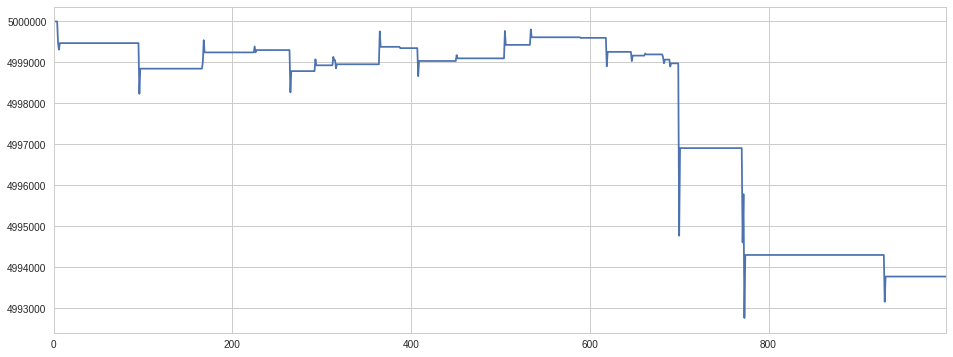

In [33]:
value, reward = env.plot_data()

pd.Series(value).plot(figsize=(16, 6))

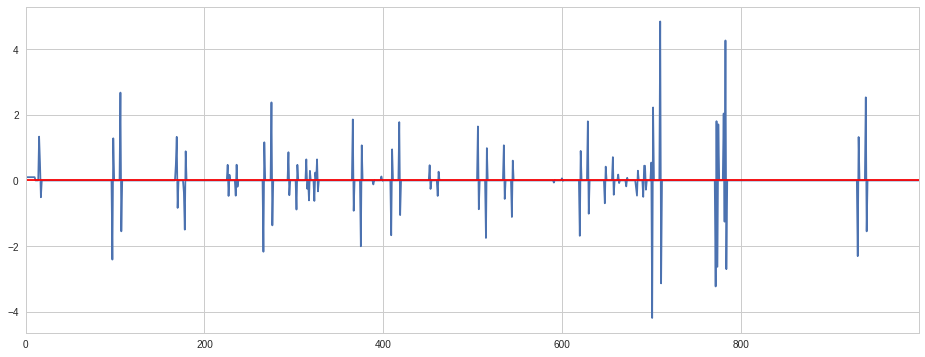

In [34]:
pd.Series(reward).plot(figsize=(16,6))
pd.Series(np.zeros_like(reward)).plot(figsize=(16,6), color='r')